In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import optuna

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

# Data Collection

In [2]:
train_path = '/kaggle/input/titanic/train.csv'
test_path = '/kaggle/input/titanic/test.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [7]:
train_df['Survived'].value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

# 2. Data Cleaning

In [8]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
test_df['Age'] = test_df['Age'].fillna(train_df['Age'].median())
test_df['Embarked'] = test_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


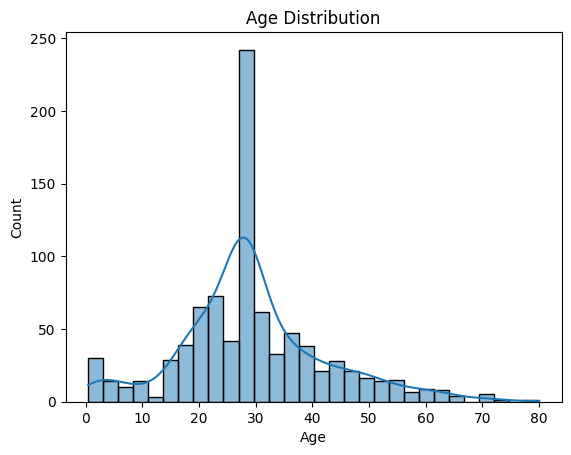

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


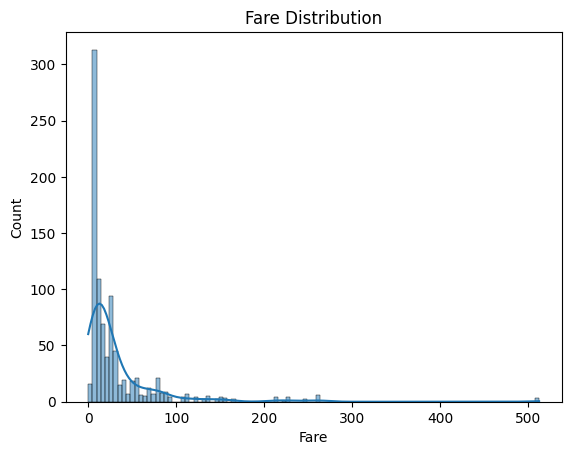

In [9]:
sns.histplot(train_df['Age'], kde=True)
plt.title('Age Distribution')
plt.show()

sns.histplot(train_df['Fare'], kde=True)
plt.title('Fare Distribution')
plt.show()

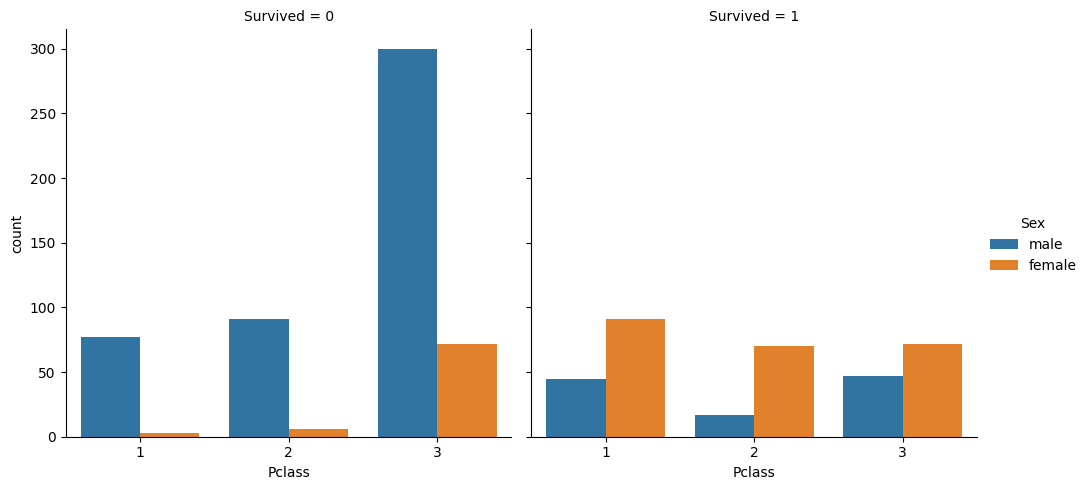

In [10]:
sns.catplot(x='Pclass', hue='Sex', col='Survived', data=train_df, kind='count')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

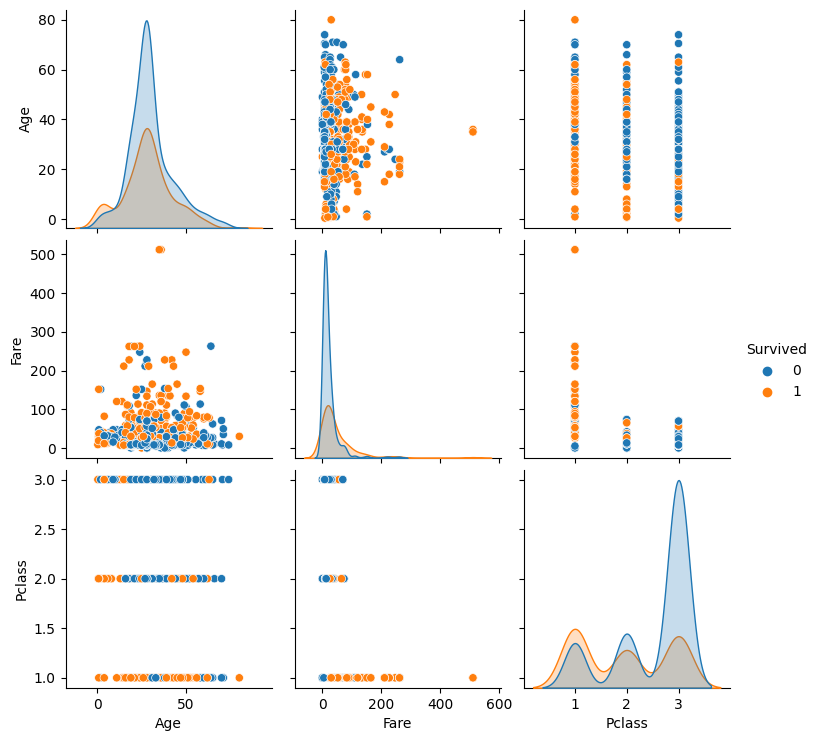

In [11]:
sns.pairplot(train_df[['Age', 'Fare', 'Pclass', 'Survived']], hue='Survived')
plt.show()

This pairplot shows the relationship between 'Age', 'Fare', and 'Pclass' with the 'Survived'

Age vs. Survived: Younger passengers had a higher survival rate, but many older passengers also survived.
Fare vs. Survived: Passengers who paid higher fares had a better chance of survival, likely because they were in higher classes.
Pclass vs. Survived: Passengers in first class had a higher survival rate, while those in third class had the lowest.

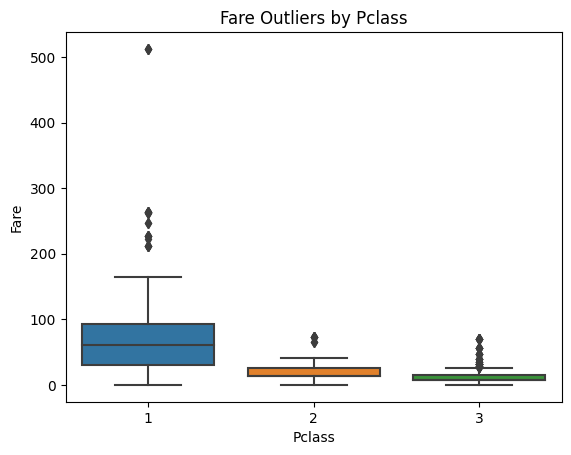

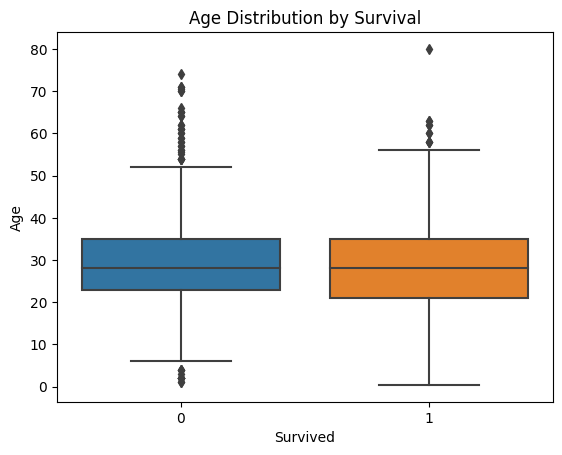

In [12]:
sns.boxplot(x='Pclass', y='Fare', data=train_df)
plt.title('Fare Outliers by Pclass')
plt.show()

sns.boxplot(x='Survived', y='Age', data=train_df)
plt.title('Age Distribution by Survival')
plt.show()

1. Fare Outliers by Pclass

Pclass 1: Passengers in first class paid significantly higher fares, with several outliers indicating very high fares.
Pclass 2 and 3: Fares for second and third-class passengers were generally lower, with fewer outliers, but still some notable high fares in third class.
2. Age Distribution by Survival

Survived: The median age of survivors is slightly higher than non-survivors, with a wider spread.
Not Survived: Non-survivors have a more concentrated age distribution around the median, with more younger and older individuals represented among the outliers.

In [13]:
train_df = train_df.drop(columns=['Name', 'Ticket'])
test_df = test_df.drop(columns=['Name', 'Ticket'])

In [14]:
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
train_df['Embarked'] = train_df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})
test_df['Embarked'] = test_df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [15]:
train_df['CabinDeck'] = train_df['Cabin'].apply(lambda x: str(x)[0] if pd.notnull(x) else 'Unknown')
train_df['CabinKnown'] = train_df['Cabin'].apply(lambda x: 0 if pd.isnull(x) else 1)

test_df['CabinDeck'] = test_df['Cabin'].apply(lambda x: str(x)[0] if pd.notnull(x) else 'Unknown')
test_df['CabinKnown'] = test_df['Cabin'].apply(lambda x: 0 if pd.isnull(x) else 1)

train_df = train_df.drop(columns=['Cabin'])
test_df = test_df.drop(columns=['Cabin'])

In [16]:
sns.barplot(x='FamilySize', y='Survived', data=train_df)
plt.title('Survival Rate by Family Size')
plt.show()

sns.barplot(x='IsAlone', y='Survived', data=train_df)
plt.title('Survival Rate by IsAlone')
plt.show()

ValueError: Could not interpret input 'FamilySize'

In [ ]:
threshold = 0.1  # Set a threshold for correlation with Survived
corr_matrix = train_df.corr()

corr_with_target = corr_matrix['Survived'].abs()
features_to_keep = corr_with_target[corr_with_target > threshold].index
filtered_corr_matrix = train_df[features_to_keep].corr()

plt.figure(figsize=(14, 10))  # Increase the figure size
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Filtered Correlation Matrix', fontsize=18)
plt.show()

In [ ]:
epsilon = 0.001

train_df['Pclass_Sex'] = (train_df['Pclass'] + epsilon) * (train_df['Sex'] + epsilon)
train_df['Pclass_Fare'] = (train_df['Pclass'] + epsilon) * (train_df['Fare'] + epsilon)
train_df['Pclass_CabinDeck'] = (train_df['Pclass'] + epsilon) * (train_df['CabinDeck'] + epsilon)
train_df['Sex_IsAlone'] = (train_df['Sex'] + epsilon) * (train_df['IsAlone'] + epsilon)
train_df['CabinKnown_FarePerPerson'] = (train_df['CabinKnown'] + epsilon) * (train_df['FarePerPerson'] + epsilon)
train_df['Fare_FamilySize'] = (train_df['Fare'] + epsilon) * (train_df['FamilySize'] + epsilon)

test_df['Pclass_Sex'] = (test_df['Pclass'] + epsilon) * (test_df['Sex'] + epsilon)
test_df['Pclass_Fare'] = (test_df['Pclass'] + epsilon) * (test_df['Fare'] + epsilon)
test_df['Pclass_CabinDeck'] = (test_df['Pclass'] + epsilon) * (test_df['CabinDeck'] + epsilon)
test_df['Sex_IsAlone'] = (test_df['Sex'] + epsilon) * (test_df['IsAlone'] + epsilon)
test_df['CabinKnown_FarePerPerson'] = (test_df['CabinKnown'] + epsilon) * (test_df['FarePerPerson'] + epsilon)
test_df['Fare_FamilySize'] = (test_df['Fare'] + epsilon) * (test_df['FamilySize'] + epsilon)

In [ ]:
skewness = train_df.skew().sort_values(ascending=False)
print(skewness)

In [ ]:
skewed_features = skewness[skewness > 0.5].index
train_df[skewed_features] = np.log1p(train_df[skewed_features])

In [ ]:
X = train_df.drop(columns=['Survived', 'PassengerId'])
y = train_df['Survived']

X_test = test_df.drop(columns=['PassengerId'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Best parameters from Optuna
best_params = {
    'iterations': 177,
    'depth': 7,
    'learning_rate': 0.04102330816314412,
    'l2_leaf_reg': 21.425243910932267,
    'border_count': 72,
    'random_strength': 6.0241013536074686e-09
}

model = CatBoostClassifier(**best_params, verbose=0)
model.fit(X_train, y_train)

In [ ]:
feature_importances = model.get_feature_importance(prettified=True)
print(feature_importances)

In [ ]:
predictions = model.predict(X_test)
predictions

In [ ]:
model.save_model('catboost_best_model.cbm')

In [ ]:
output = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
output['Survived'] = predictions

In [ ]:
output.to_csv('submission.csv', index=False)